# Лабораторная работа 2. Глубокое обучение

In [ ]:
import pandas as pd
import re
import os
import json
import math
import torch
import logging

from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Загрузим данные и посмотрим на них. Затем приведем все это к виду датафрейма и проведем первичную предобработку, чтобы дальше было удобнее работать

In [2]:
def load_data(file_path):
    with open(file_path, 'r', encoding='latin-1') as file:
        data = file.readlines()
    return data

file_path = './movie_lines.txt'
data = load_data(file_path)
print("Количество строк:", len(data))
print("Пример строки:", data[0])

Количество строк: 304713
Пример строки: L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!



In [5]:
df = pd.DataFrame(data)
df.head()

,0
0,L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++...
1,L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON ++...
2,L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...
3,L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++...
4,L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...


In [6]:
df.columns = ['all']

df = df['all'].str.split(r'\s+\+\+\+\$\+\+\+\s+', expand=True)
df.columns = ['line_id', 'character_id', 'movie_id', 'character', 'text']
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

df.head()

,line_id,character_id,movie_id,character,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [ ]:
df.to_csv("./movie_dialogues.csv", index=False)
len(df)

304713

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   line_id       304713 non-null  object
 1   character_id  304713 non-null  object
 2   movie_id      304713 non-null  object
 3   character     304713 non-null  object
 4   text          304670 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB


Пропуски удалим, так как они могут помешать дальнейшему обучению и нормальному функционированию моделей. Удаляем потому что пропуски в столбце с репликами - именно том столбце, который нам непосредственно и нужен, поэтому при удалении ничего не теряем

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304670 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   line_id       304670 non-null  object
 1   character_id  304670 non-null  object
 2   movie_id      304670 non-null  object
 3   character     304670 non-null  object
 4   text          304670 non-null  object
dtypes: object(5)
memory usage: 13.9+ MB


Посмотрим также на распредение длин текстов, количества реплик по фильмам и количество уникальных значений

In [12]:
df['text'].str.len().describe()

count    304403.000000
mean         55.325644
std          64.088439
min           1.000000
25%          19.000000
50%          35.000000
75%          69.000000
max        3046.000000
Name: text, dtype: float64

In [ ]:
df['movie_id'].value_counts()

movie_id
m289    1530
m299    1286
m105    1214
m295    1204
m238    1187
        ... 
m456      29
m406      13
m521      13
m270      11
m602       6
Name: count, Length: 617, dtype: int64

In [ ]:
print(df['character_id'].nunique())
print(df['movie_id'].nunique())

9031
617


### Предобработка данных

Выбираем случайную подвыборку для предобработки и обучения моделей, сохраняем пропорции по фильмам для разнообразия

In [ ]:

df_sample = df.groupby('movie_id', group_keys=False).apply(lambda x: x.sample(frac=22000/len(df), random_state=42) if len(x) > 0 else x)


C:\Users\Таня\AppData\Local\Temp\ipykernel_2528\2577531514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('movie_id', group_keys=False).apply(lambda x: x.sample(frac=22000/len(df), random_state=42) if len(x) > 0 else x)


In [ ]:
print(df_sample.shape)
print(df_sample['movie_id'].nunique())

(21997, 5)
616


Создадим список для хранения диалогов (в формате реплика - ответ), при этом группируем по id фильма, чтобы работать с диалогами в пределах каждого отдельного фильма. Затем проведем предобработку текстов

In [ ]:
dialogues = []

for movie_id in df_sample['movie_id'].unique():
    movie_df = df_sample[df_sample['movie_id'] == movie_id].sort_values('line_id')
    for i in range(len(movie_df) - 1):
        context = movie_df.iloc[i]['text']
        response = movie_df.iloc[i + 1]['text']
        dialogues.append({
            'movie_id': movie_id,
            'context': context,
            'response': response
        })

dialogues_df = pd.DataFrame(dialogues)

In [ ]:
dialogues_df.head()

,movie_id,context,response
0,m0,Let go!,"Katarina Stratford. My, my. You've been terr..."
1,m0,"Katarina Stratford. My, my. You've been terr...","Besides, I had some extra cash. Some asshole p..."
2,m0,"Besides, I had some extra cash. Some asshole p...",Perm?
3,m0,Perm?,"Yeah, and I noticed the only part of you featu..."
4,m0,"Yeah, and I noticed the only part of you featu...",Make anyone cry today?


In [ ]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

dialogues_df['context'] = dialogues_df['context'].apply(clean_text)
dialogues_df['response'] = dialogues_df['response'].apply(clean_text)

In [ ]:
dialogues_df.head()

,movie_id,context,response
0,m0,let go!,"katarina stratford. my, my. you've been terror..."
1,m0,"katarina stratford. my, my. you've been terror...","besides, i had some extra cash. some asshole p..."
2,m0,"besides, i had some extra cash. some asshole p...",perm?
3,m0,perm?,"yeah, and i noticed the only part of you featu..."
4,m0,"yeah, and i noticed the only part of you featu...",make anyone cry today?


### Обучение и оценка первой тестовой модели

Для начала создаем папки для сохранения логов на случай, если что-то внезапно сломается и придется восстанавливать. Также на этом этапе объвляем вспомогательные функции для расчета метрик

In [ ]:
log_dir = './logs'
checkpoint_dir = './checkpoints'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

logging.basicConfig(
    filename=os.path.join(log_dir, 'train.log'),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

metrics_path = os.path.join(log_dir, 'metrics.json')
metrics = []

def save_metrics(epoch, train_loss, val_loss=None):
    entry = {
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    metrics.append(entry)
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)

def save_checkpoint(epoch):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics
    }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt'))

def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint.get('metrics', [])

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Теперь готовим данные, делим их на обучающее, валидационное и тестовое множества с сохранением пропорций по отдельным фильмам

In [ ]:
movie_counts = dialogues_df['movie_id'].value_counts()
valid_movies = movie_counts[movie_counts >= 2].index
filtered_dialogues_df = dialogues_df[dialogues_df['movie_id'].isin(valid_movies)]

train_df, temp_df = train_test_split(
    filtered_dialogues_df, test_size=0.3, random_state=42, stratify=filtered_dialogues_df['movie_id'])

temp_movie_counts = temp_df['movie_id'].value_counts()
valid_temp_movies = temp_movie_counts[temp_movie_counts >= 2].index
filtered_temp_df = temp_df[temp_df['movie_id'].isin(valid_temp_movies)]

val_df, test_df = train_test_split(
    filtered_temp_df, test_size=0.5, random_state=42, stratify=filtered_temp_df['movie_id'])

print(f"Train set: {len(train_df)} строк ({len(train_df)/len(filtered_dialogues_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} строк ({len(val_df)/len(filtered_dialogues_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} строк ({len(test_df)/len(filtered_dialogues_df)*100:.1f}%)")

print("\nУникальных фильмов в наборах:")
print(f"Train: {train_df['movie_id'].nunique()}")
print(f"Validation: {val_df['movie_id'].nunique()}")
print(f"Test: {test_df['movie_id'].nunique()}")

Train set: 14965 строк (70.0%)
Validation set: 3204 строк (15.0%)
Test set: 3205 строк (15.0%)

Уникальных фильмов в наборах:
Train: 611
Validation: 606
Test: 606


Смотрим, что все хорошо предобработалось и правильно сохранилось

In [ ]:
train_df.head()

,movie_id,context,response
14525,m467,listen to miss smarty mouth. out there in the ...,"happy birthday, kid. you want another coke?"
10323,m35,right on the button.,i've got goose-bumps all over me.
478,m105,where're you going?,i thought you were tired of your business?
11767,m39,last week? when?,please -- i'm only here because of paris -- be...
5475,m231,between ten and twelve. once a nine- year-old ...,walter.


Теперь для дальнейшей работы нужно токенизировать датасеты и преобразовать их сначала в вид TensorDataset, а затем уже в вид DataLoader

In [ ]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def format_text(row):
    return f"{row['context']} [SEP] {row['response']}"

train_texts = [format_text(row) for _, row in train_df.iterrows()]
val_texts = [format_text(row) for _, row in val_df.iterrows()]
test_texts = [format_text(row) for _, row in test_df.iterrows()]

def tokenize_batch(texts):
    return tokenizer(texts, return_tensors='pt', truncation=True, max_length=128, padding='max_length')['input_ids']

train_inputs = tokenize_batch(train_texts)
val_inputs = tokenize_batch(val_texts)
test_inputs = tokenize_batch(test_texts)

train_dataset = TensorDataset(train_inputs)
val_dataset = TensorDataset(val_inputs)
test_dataset = TensorDataset(test_inputs)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Инициализируем модель gpt-2 и настраиваем основные параметры для нее

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.config.pad_token_id = tokenizer.pad_token_id

learning_rate = 5e-5
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=learning_rate)

model = model.to(device)

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Обучаем тестовую модель и делаем ее оценку ранее заявленым метрикам

In [ ]:
start_epoch = 0

model.train()
for epoch in range(start_epoch, num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        inputs = batch[0].to(device)
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    logging.info(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs, labels=inputs)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    logging.info(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

    save_metrics(epoch + 1, avg_train_loss, avg_val_loss)
    save_checkpoint(epoch + 1)
    model.train()

Эпоха 1/3:   0%|          | 0/1871 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
Эпоха 3/3: 100%|██████████| 1871/1871 [18:46<00:00,  1.66it/s, loss=0.917]


In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs, labels=inputs)
        total_loss += outputs.loss.item()

avg_loss = total_loss / len(val_loader)
perplexity = math.exp(avg_loss)
logging.info(f"Final Validation Perplexity: {perplexity:.2f}")
print(f"Validation Perplexity: {perplexity:.2f}")

model.save_pretrained('./gpt2_finetuned')
tokenizer.save_pretrained('./gpt2_finetuned')

Validation Perplexity: 2.08


('./gpt2_finetuned\\tokenizer_config.json',
 './gpt2_finetuned\\special_tokens_map.json',
 './gpt2_finetuned\\vocab.json',
 './gpt2_finetuned\\merges.txt',
 './gpt2_finetuned\\added_tokens.json')

Финальное значение Perplexity на валидации составило 2.08, что кажется довольно неплохим результатом, однако хотелось бы получить значение еще ближе к 1

### Обучение набора моделей с разными оптимизаторами

Следующий этап - сравнить работу моделей с использованием разных оптимизаторов, для этого таким же образом, как и ранее, подготавливаем функции для метрик, данные и запускаем эксперименты!

In [ ]:
LOG_DIR = "logs"
LOG_FILE = os.path.join(LOG_DIR, "metrics_log.json")

os.makedirs(LOG_DIR, exist_ok=True)

def calculate_perplexity(loss):
    return math.exp(loss)

def calculate_bleu(reference_texts, generated_texts):
    smooth_fn = SmoothingFunction().method1
    scores = [
        sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth_fn)
        for ref, gen in zip(reference_texts, generated_texts)
    ]
    return sum(scores) / len(scores) if scores else 0.0

def calculate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(gen, ref) for ref, gen in zip(reference_texts, generated_texts)]
    avg_scores = {
        'rouge1': sum(s['rouge1'].fmeasure for s in scores) / len(scores),
        'rouge2': sum(s['rouge2'].fmeasure for s in scores) / len(scores),
        'rougeL': sum(s['rougeL'].fmeasure for s in scores) / len(scores)
    }
    return avg_scores

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def train_model(name, model, optimizer, scheduler, num_epochs, train_loader, val_loader, device, tokenizer):
    train_losses, val_losses, val_perplexities = [], [], []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        print(f"[{name}] Эпоха {epoch+1}/{num_epochs} — обучение")
        for batch in tqdm(train_loader, desc="Тренировка", leave=False):
            inputs = batch[0].to(device)
            model.zero_grad()
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        all_refs, all_gens = [], []

        print(f"[{name}] Эпоха {epoch+1}/{num_epochs} — валидация")
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Валидация", leave=False):
                inputs = batch[0].to(device)
                outputs = model(inputs, labels=inputs)
                loss = outputs.loss
                total_val_loss += loss.item()

                decoded = tokenizer.batch_decode(inputs, skip_special_tokens=True)
                all_refs.extend(decoded)
                all_gens.extend(decoded)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        perplexity = calculate_perplexity(avg_val_loss)
        val_perplexities.append(perplexity)
        bleu_score = calculate_bleu(all_refs, all_gens)
        rouge_scores = calculate_rouge(all_refs, all_gens)

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Perplexity: {perplexity:.2f} | BLEU: {bleu_score:.4f} | ROUGE: {rouge_scores}")

        log_data = {
            "experiment": name,
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "perplexity": perplexity,
            "bleu": bleu_score,
            "rouge1": rouge_scores['rouge1'],
            "rouge2": rouge_scores['rouge2'],
            "rougeL": rouge_scores['rougeL'],
        }
        with open(LOG_FILE, "a") as f:
            json.dump(log_data, f)
            f.write("\n")

    save_dir = f"saved_models/{name}"
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"\n Модель '{name}' сохранена в: {save_dir}")

    return train_losses, val_losses, val_perplexities

In [ ]:
def run_experiments(train_loader, val_loader, tokenizer, device, num_epochs):
    optimizers = {
        "adam": lambda model: AdamW(model.parameters(), lr=5e-5),
        "adam_sched": lambda model: AdamW(model.parameters(), lr=5e-5),
        "sgd": lambda model: optim.SGD(model.parameters(), lr=1e-3),
        "rmsprop": lambda model: optim.RMSprop(model.parameters(), lr=1e-4)
    }

    for name, optimizer_fn in optimizers.items():
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        model.resize_token_embeddings(len(tokenizer))
        optimizer = optimizer_fn(model)
        scheduler = None

        if name == "adam_sched":
            total_steps = len(train_loader) * num_epochs
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

        train_model(name, model, optimizer, scheduler, num_epochs, train_loader, val_loader, device, tokenizer)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_experiments(train_loader, val_loader, tokenizer, device, num_epochs=3)

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



[adam] Эпоха 1/3 — обучение


[adam] Эпоха 1/3 — валидация


Train Loss: 0.8548 | Val Loss: 0.7923 | Perplexity: 2.21 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[adam] Эпоха 2/3 — обучение


[adam] Эпоха 2/3 — валидация


Train Loss: 0.7657 | Val Loss: 0.7612 | Perplexity: 2.14 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[adam] Эпоха 3/3 — обучение


[adam] Эпоха 3/3 — валидация


Train Loss: 0.6980 | Val Loss: 0.7354 | Perplexity: 2.09 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

 Модель 'adam' сохранена в: saved_models/adam


C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



[adam_sched] Эпоха 1/3 — обучение


[adam_sched] Эпоха 1/3 — валидация


Train Loss: 0.9312 | Val Loss: 0.8029 | Perplexity: 2.23 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[adam_sched] Эпоха 2/3 — обучение


[adam_sched] Эпоха 2/3 — валидация


Train Loss: 0.7899 | Val Loss: 0.7831 | Perplexity: 2.19 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[adam_sched] Эпоха 3/3 — обучение


[adam_sched] Эпоха 3/3 — валидация


Train Loss: 0.7533 | Val Loss: 0.7759 | Perplexity: 2.17 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

 Модель 'adam_sched' сохранена в: saved_models/adam_sched

[sgd] Эпоха 1/3 — обучение


[sgd] Эпоха 1/3 — валидация


Train Loss: 0.9668 | Val Loss: 0.8754 | Perplexity: 2.40 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[sgd] Эпоха 2/3 — обучение


[sgd] Эпоха 2/3 — валидация


Train Loss: 0.8981 | Val Loss: 0.8604 | Perplexity: 2.36 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[sgd] Эпоха 3/3 — обучение


[sgd] Эпоха 3/3 — валидация


Train Loss: 0.8844 | Val Loss: 0.8528 | Perplexity: 2.35 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

 Модель 'sgd' сохранена в: saved_models/sgd

[rmsprop] Эпоха 1/3 — обучение


[rmsprop] Эпоха 1/3 — валидация


Train Loss: 0.8565 | Val Loss: 0.7852 | Perplexity: 2.19 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[rmsprop] Эпоха 2/3 — обучение


[rmsprop] Эпоха 2/3 — валидация


Train Loss: 0.7245 | Val Loss: 0.7438 | Perplexity: 2.10 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

[rmsprop] Эпоха 3/3 — обучение


[rmsprop] Эпоха 3/3 — валидация


Train Loss: 0.6211 | Val Loss: 0.7124 | Perplexity: 2.04 | BLEU: 0.9969 | ROUGE: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}

 Модель 'rmsprop' сохранена в: saved_models/rmsprop


Для наглядности сравним метрики моделей на графике и в табличном виде

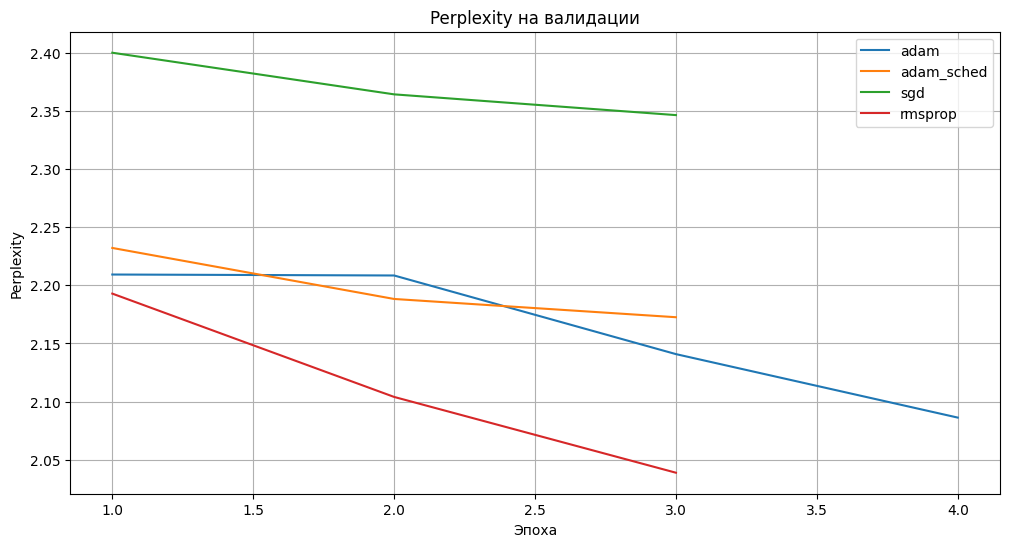

In [ ]:
def plot_perplexity():
    experiments = {}
    with open(LOG_FILE, "r") as f:
        for line in f:
            log = json.loads(line)
            exp = log["experiment"]
            if exp not in experiments:
                experiments[exp] = []
            experiments[exp].append(log["perplexity"])

    plt.figure(figsize=(12, 6))
    for name, perplexities in experiments.items():
        plt.plot(range(1, len(perplexities)+1), perplexities, label=name)
    plt.xlabel("Эпоха")
    plt.ylabel("Perplexity")
    plt.title("Perplexity на валидации")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_perplexity()

In [ ]:
def print_experiment_summary():
    records = []
    with open(LOG_FILE, "r") as f:
        for line in f:
            log = json.loads(line)
            records.append(log)

    df = pd.DataFrame(records)
    summary = df.groupby("experiment")[["val_loss", "perplexity", "bleu", "rouge1", "rouge2", "rougeL"]].mean().reset_index()
    print("\nРезультаты по экспериментам:")
    print(summary.to_string(index=False))

print_experiment_summary()


Результаты по экспериментам:
experiment  val_loss  perplexity     bleu  rouge1  rouge2  rougeL
      adam  0.770370    2.161181 0.995849     1.0     1.0     1.0
adam_sched  0.787309    2.197620 0.996858     1.0     1.0     1.0
   rmsprop  0.747144    2.111902 0.996858     1.0     1.0     1.0
       sgd  0.862895    2.370117 0.996858     1.0     1.0     1.0


Таким образом, можно сделать вывод, что лучшие результаты по метрике perplexity показала модель, для которой использовался оптимизатор rmsprop. Кроме того для этой модели самый низкий лосс на валидации, что свидетельствует о хорошем результате. 

Далее проведем ручную проверку: дадим модели контекст и посмотрим на сгенерированный ответ

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_path = "./saved_models/rmsprop"
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)

def generate_responses(model, tokenizer, prompts, device, max_length=50):
    model.eval()
    model.to(device)
    responses = []

    with torch.no_grad():
        for prompt in prompts:
            # Добавляем [SEP] вручную, чтобы имитировать формат обучения
            input_text = prompt.strip() + " [SEP]"
            inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

            outputs = model.generate(
                inputs,
                max_length=max_length,
                num_beams=5,
                early_stopping=True,
                pad_token_id=tokenizer.eos_token_id
            )
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Извлекаем только часть после [SEP]
            if "[SEP]" in decoded:
                decoded = decoded.split("[SEP]", 1)[-1].strip()

            responses.append((prompt, decoded))
    return responses


sample_prompts = [
    "hello",
    "how do you do?",
    "what is that",
]

generated = generate_responses(model, tokenizer, sample_prompts, device)

for i, (inp, out) in enumerate(generated):
    print(f"\n[{i+1}] Вопрос: {inp}")
    print(f"Ответ модели: {out}")


[1] Вопрос: hello
Ответ модели: i don't know what you're talking about.

[2] Вопрос: how do you do?
Ответ модели: how do you do?

[3] Вопрос: what is that
Ответ модели: what's the matter with you?


На самом-то деле не совсем понятно, как модель генерирует ответ, так как в некоторых случаях она дает ответы, не совсем соотносящиеся с вопросом. Попробуем запустить интерактивное тестирование в формате чат-бота

In [8]:
model_path = "./saved_models/rmsprop"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
print("Добро пожаловать в чат! Введите ваш запрос или 'exit' для выхода.")

while True:
    try:
        user_input = input("Введите ваш запрос: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Чат завершен. До свидания!")
            break

        input_text = user_input.strip() + " [SEP]"
        inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

        outputs = model.generate(
            inputs,
            max_length=50,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "[SEP]" in decoded:
            response = decoded.split("[SEP]", 1)[-1].strip()
        else:
            response = decoded.strip()

        print(f"Ваш запрос: {user_input}")
        print(f"Ответ модели: {response}\n")

    except Exception as e:
        print("Произошла ошибка:", str(e))
        print("Попробуйте еще раз")

Добро пожаловать в чат! Введите ваш запрос или 'exit' для выхода.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Ваш запрос: hello
Ответ модели: good morning, john. your father...

Ваш запрос: how are you?
Ответ модели: i'm not getting any younger, am i, ted?

Ваш запрос: how do you do?
Ответ модели: i do!

Чат завершен. До свидания!


### Улучшеная версия

Для улучшения модели было решено попробовать увеличить объем данных, на которых происходит обучение и немного изменить концепт самой модели. Для дальнейшего улучшения была выбрана модель с оптимизатором rmsprop, так как именно она показала лучшие результаты на предыдущем этапе

In [ ]:
df_sample = df.groupby('movie_id', group_keys=False).apply(lambda x: x.sample(frac=101000/len(df), random_state=42) if len(x) > 0 else x)
dialogues = []

for movie_id in df_sample['movie_id'].unique():
    movie_df = df_sample[df_sample['movie_id'] == movie_id].sort_values('line_id')
    for i in range(len(movie_df) - 1):
        context = movie_df.iloc[i]['text']
        response = movie_df.iloc[i + 1]['text']
        dialogues.append({
            'movie_id': movie_id,
            'context': context,
            'response': response
        })

dialogues_df = pd.DataFrame(dialogues)

C:\Users\Таня\AppData\Local\Temp\ipykernel_15052\3923590567.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('movie_id', group_keys=False).apply(lambda x: x.sample(frac=101000/len(df), random_state=42) if len(x) > 0 else x)


In [14]:
dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100372 entries, 0 to 100371
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   movie_id  100372 non-null  object
 1   context   100372 non-null  object
 2   response  100372 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

dialogues_df['context'] = dialogues_df['context'].apply(clean_text)
dialogues_df['response'] = dialogues_df['response'].apply(clean_text)

movie_counts = dialogues_df['movie_id'].value_counts()
valid_movies = movie_counts[movie_counts >= 2].index
filtered_dialogues_df = dialogues_df[dialogues_df['movie_id'].isin(valid_movies)]

train_df, temp_df = train_test_split(filtered_dialogues_df, test_size=0.3, random_state=42, stratify=filtered_dialogues_df['movie_id'])
temp_movie_counts = temp_df['movie_id'].value_counts()
valid_temp_movies = temp_movie_counts[temp_movie_counts >= 2].index
filtered_temp_df = temp_df[temp_df['movie_id'].isin(valid_temp_movies)]
val_df, test_df = train_test_split(filtered_temp_df, test_size=0.5, random_state=42, stratify=filtered_temp_df['movie_id'])

def get_input_and_label(row):
    input_text = f"User: {row['context']}\nBot:"
    label_text = f" {row['response']}"
    return input_text, label_text

train_inputs, train_labels = zip(*[get_input_and_label(row) for _, row in train_df.iterrows()])
val_inputs, val_labels = zip(*[get_input_and_label(row) for _, row in val_df.iterrows()])
test_inputs, test_labels = zip(*[get_input_and_label(row) for _, row in test_df.iterrows()])

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' 

def tokenize_inputs_and_labels(inputs, labels):
    input_encodings = tokenizer(list(inputs), return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    label_encodings = tokenizer(list(labels), return_tensors='pt', padding='max_length', truncation=True, max_length=128)

    labels = label_encodings['input_ids']
    labels[labels == tokenizer.pad_token_id] = -100

    return input_encodings['input_ids'], input_encodings['attention_mask'], labels

train_input_ids, train_masks, train_labels = tokenize_inputs_and_labels(train_inputs, train_labels)
val_input_ids, val_masks, val_labels = tokenize_inputs_and_labels(val_inputs, val_labels)
test_input_ids, test_masks, test_labels = tokenize_inputs_and_labels(test_inputs, test_labels)

train_dataset = TensorDataset(train_input_ids, train_labels, train_masks)
val_dataset = TensorDataset(val_input_ids, val_labels, val_masks)
test_dataset = TensorDataset(test_input_ids, test_labels, test_masks)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import json
import math
import torch
from tqdm import tqdm
from transformers import GPT2LMHeadModel
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(device)
model.train()

optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

def calculate_bleu(reference_texts, generated_texts):
    smooth_fn = SmoothingFunction().method1
    scores = [
        sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth_fn)
        for ref, gen in zip(reference_texts, generated_texts)
    ]
    return sum(scores) / len(scores)

def calculate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(gen, ref) for ref, gen in zip(generated_texts, reference_texts)]
    avg_scores = {
        'rouge1': sum(s['rouge1'].fmeasure for s in scores) / len(scores),
        'rouge2': sum(s['rouge2'].fmeasure for s in scores) / len(scores),
        'rougeL': sum(s['rougeL'].fmeasure for s in scores) / len(scores),
    }
    return avg_scores

def calculate_perplexity(loss):
    return math.exp(loss)

def train_model(model, optimizer, num_epochs, train_loader, val_loader, device, tokenizer, eval_generation=False):
    train_losses, val_losses, val_perplexities = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        print(f"\nЭпоха {epoch + 1}/{num_epochs} — обучение")
        for input_ids, labels, attention_mask in tqdm(train_loader, desc="Тренировка", leave=False):
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = attention_mask.to(device)

            model.zero_grad()
            outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        val_refs = []
        val_gens = []

        print(f"Эпоха {epoch + 1}/{num_epochs} — валидация")
        with torch.no_grad():
            for input_ids, labels, attention_mask in tqdm(val_loader, desc="Валидация", leave=False):
                input_ids = input_ids.to(device)
                labels = labels.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
                loss = outputs.loss
                total_val_loss += loss.item()

                if eval_generation:
                    generated_ids = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=50,
                        do_sample=True,
                        top_k=50,
                        top_p=0.95,
                        temperature=0.7,
                        pad_token_id=tokenizer.eos_token_id
                    )
                    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

                    cleaned_labels = []
                    for label_seq in labels:
                        tokens = [token.item() for token in label_seq if token.item() != -100]
                        text = tokenizer.decode(tokens, skip_special_tokens=True)
                        cleaned_labels.append(text)

                    val_gens.extend(decoded_preds)
                    val_refs.extend(cleaned_labels)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        perplexity = calculate_perplexity(avg_val_loss)
        val_perplexities.append(perplexity)

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Perplexity: {perplexity:.2f}")

        log_data = {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "perplexity": perplexity
        }

        if eval_generation and val_gens:
            bleu = calculate_bleu(val_refs, val_gens)
            rouge = calculate_rouge(val_refs, val_gens)
            log_data.update({
                "bleu": bleu,
                "rouge1": rouge['rouge1'],
                "rouge2": rouge['rouge2'],
                "rougeL": rouge['rougeL']
            })

            print(f"BLEU: {bleu:.4f} | ROUGE-1: {rouge['rouge1']:.4f} | ROUGE-2: {rouge['rouge2']:.4f} | ROUGE-L: {rouge['rougeL']:.4f}")

        with open("metrics_log.json", "a") as f:
            json.dump(log_data, f)
            f.write("\n")

    model.save_pretrained("saved_model_1/rmsprop_update")
    tokenizer.save_pretrained("saved_model_1/rmsprop_update")
    print("\nМодель сохранена в 'saved_model_1/rmsprop_update'")

    return train_losses, val_losses, val_perplexities

In [17]:
train_model(model, optimizer, num_epochs=3, train_loader=train_loader, val_loader=val_loader, device=device, tokenizer=tokenizer, eval_generation=True)


Эпоха 1/3 — обучение


Тренировка:   0%|          | 0/8783 [00:00<?, ?it/s]

Эпоха 1/3 — валидация


Train Loss: 6.0508 | Val Loss: 6.0017 | Perplexity: 404.13
BLEU: 0.0043 | ROUGE-1: 0.1006 | ROUGE-2: 0.0060 | ROUGE-L: 0.0784

Эпоха 2/3 — обучение


Эпоха 2/3 — валидация


Train Loss: 5.9961 | Val Loss: 5.9935 | Perplexity: 400.80
BLEU: 0.0043 | ROUGE-1: 0.0997 | ROUGE-2: 0.0059 | ROUGE-L: 0.0778

Эпоха 3/3 — обучение


Эпоха 3/3 — валидация


Train Loss: 5.9807 | Val Loss: 6.0342 | Perplexity: 417.47
BLEU: 0.0043 | ROUGE-1: 0.1007 | ROUGE-2: 0.0058 | ROUGE-L: 0.0780

Модель сохранена в 'saved_model_1/rmsprop_update'


([6.050756381392194, 5.996117649351995, 5.9806634600988],
 [6.00173992482306, 5.9934508141751754, 6.034217603908462],
 [404.13134027692746, 400.7952964009316, 417.4720533257188])

Как итог - получилось очень большое значение Perplexity. Можно сделать предположение, что либо на предыдущем этапе в настройке моделей была допущена ошибка, либо уже на этом этапе.

Попробуем провести оценку работы модели

In [2]:
# --- Оценка модели ---
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import json
from tqdm import tqdm

def calculate_bleu(reference_texts, generated_texts):
    smooth_fn = SmoothingFunction().method1
    scores = [sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth_fn) for ref, gen in zip(reference_texts, generated_texts)]
    return sum(scores) / len(scores)

def calculate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(gen, ref) for ref, gen in zip(reference_texts, generated_texts)]
    avg_scores = {
        'rouge1': sum(s['rouge1'].fmeasure for s in scores) / len(scores),
        'rouge2': sum(s['rouge2'].fmeasure for s in scores) / len(scores),
        'rougeL': sum(s['rougeL'].fmeasure for s in scores) / len(scores)
    }
    return avg_scores

def evaluate_model(model, test_loader, device, tokenizer):
    model.eval()
    all_gens = []
    all_refs = []

    with torch.no_grad():
        for input_ids, references, attention_mask in tqdm(test_loader, desc="Тестирование", leave=False):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Генерация
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )

            # Декодирование генерации
            generated = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Обработка и декодирование ссылок
            cleaned_refs = []
            for label_seq in references:
                label_ids = [token.item() for token in label_seq if token.item() != -100]
                if label_ids:
                    text = tokenizer.decode(label_ids, skip_special_tokens=True)
                    cleaned_refs.append(text)
                else:
                    cleaned_refs.append("")  # Пустая строка для случаев, где всё -100

            # Сбор результатов
            all_gens.extend(generated)
            all_refs.extend(cleaned_refs)

    # Примеры
    print("\nПримеры генерации:")
    for i in range(min(5, len(all_gens))):
        print(f"[{i + 1}]")
        print(f"Reference: {all_refs[i]}")
        print(f"Generated: {all_gens[i]}\n")

    # Метрики
    bleu = calculate_bleu(all_refs, all_gens)
    rouge = calculate_rouge(all_refs, all_gens)

    metrics = {
        "bleu": bleu,
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"]
    }

    with open("test_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    print("\nМетрики на тесте:")
    print(f"BLEU: {bleu:.4f}")
    print(f"ROUGE-1: {rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge['rougeL']:.4f}")

    return all_gens, metrics


In [20]:
from transformers import GPT2LMHeadModel
import torch.optim as optim
from tqdm import tqdm
import torch
import math
import json
import os
model_path = "./saved_model_1/rmsprop_update"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

model = model.to(device)
evaluate_model(model=model, test_loader=test_loader, device=device, tokenizer=tokenizer)


Примеры генерации:
[1]
Reference:  -- burn it all.
Generated: User: -- burn them.
Bot: the -- and i. my's i -- can -- that i. is my. --'s the i the you. do. the i don you't the --.. you. the, i don a -- -- you i. i i you

[2]
Reference:  they hear you comin'. they won't bother you. just don't sneak up on 'em.
Generated: User: are there snakes out here?
Bot: the, they have the'm, are... the't your <,> au>> <uuu <> ofuu</ i, iuu <u <>>>>> <u>>>u <>

[3]
Reference:  you would tell me, joseph, wouldn't you?
Generated: User: not even the slightest hint of something?
Bot: a're and,... i in,?,,, the i you, to to my i was, you, the's.,.,. the the, you of was,, and, that,'m all't we and

[4]
Reference:  i feel sorry for him.
Generated: User: why?
Bot:, i have'm this. you have if i.. the. the's, don the to you. it that. to i i...'t't... just it i.'t you, it you.,,, if...'t't...

[5]
Reference:  ecru.
Generated: User: that settles it. i'm never leaving.
Bot: was. you don be to you i't i,. and a 

(["User: -- burn them.\nBot: the -- and i. my's i -- can -- that i. is my. --'s the i the you. do. the i don you't the --.. you. the, i don a -- -- you i. i i you",
  "User: are there snakes out here?\nBot: the, they have the'm, are... the't your <,> au>> <uuu <> ofuu</ i, iuu <u <>>>>> <u>>>u <>",
  "User: not even the slightest hint of something?\nBot: a're and,... i in,?,,, the i you, to to my i was, you, the's.,.,. the the, you of was,, and, that,'m all't we and",
  "User: why?\nBot:, i have'm this. you have if i.. the. the's, don the to you. it that. to i i...'t't... just it i.'t you, it you.,,, if...'t't...",
  "User: that settles it. i'm never leaving.\nBot: was. you don be to you i't i,. and a don, for what and a you what, the.,... it you... i don, not we of you. it. don you a, if you. i is but",
  "User: instead of screaming and getting nuts, you say, okay, i'm gonna make up my mind that i fall into a magic world where i can get something special, like a poem or song. they get

Кажется, модель работает довольно странно, что подтверждает гипотезу о том, что ошибка может быть именно во второй версии

Для реализации MVP чат-бота используем наиболее успешную модель из предыдущего пункта - сохраненную модель с оптимизатором rmsprop